In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(T):
    p = T[0]; q = T[1]; r = T[2]; s = T[3]; t = T[4]; u = T[5]
    S = 0
    if p+q != 0:
        S += ((p-q)**2)/(p+q)
    if r+s != 0:
        S += ((r-s)**2)/(r+s)
    if t+u != 0:
        S += ((t-u)**2)/(t+u)
    return S

In [3]:
def DOLS_chi2(x,n,m):
    TG = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            
    #Step 1
    MCP = np.zeros((m,6)); MCN = np.zeros((m,6)) #MaxChange
    for i in range(m):
        T = TG[i]
        X = chi2(T); MCP[i] = np.zeros(6); MCN[i] = np.zeros(6)
        if T[0] >= 1:
            Y = chi2([T[0]-1, T[1], T[2]+1, T[3], T[4], T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
            Y = chi2([T[0]-1, T[1], T[2], T[3], T[4]+1, T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
        if T[1] >= 1:
            Y = chi2([T[0], T[1]-1, T[2], T[3]+1, T[4], T[5]])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
            Y = chi2([T[0], T[1]-1, T[2], T[3], T[4], T[5]+1])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
        if T[2] >= 1:
            Y = chi2([T[0]+1, T[1], T[2]-1, T[3], T[4], T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
            Y = chi2([T[0], T[1], T[2]-1, T[3], T[4]+1, T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
        if T[3] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3]-1, T[4], T[5]])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]-1, T[4], T[5]+1])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
        if T[4] >= 1:
            Y = chi2([T[0]+1, T[1], T[2], T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
            Y = chi2([T[0], T[1], T[2]+1, T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
        if T[5] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3], T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]+1, T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
    
    #Step 2
    LSS = np.zeros(int(2**m))
    for j in range(n):
        LSJ = np.zeros((m,int(2**m)))
        LSJ[0][0] = MCP[0][int(x[j][0])]; LSJ[0][1] = MCN[0][int(x[j][0])]
        #print(LSJ[0],LSJ[1])
        for i in range(1,m):
            for k in range(2**i):
                LSJ[i][2*k+0] = LSJ[i-1][k] + MCP[i][int(x[j][i])]
                LSJ[i][2*k+1] = LSJ[i-1][k] + MCN[i][int(x[j][i])]
        #print(LSJ)
        for i in range(int(2**m)):
            LSS[i] = max(LSS[i],LSJ[m-1][i])    
        #print(LSS)
        
    #Step 3
    DOLSP = np.zeros(m) #LS^{i+}
    DOLSN = np.zeros(m) #LS^{i-}
    
    for j in range(m):
        for i in range(int(2**m)):
            if int(i/(2**(m-1-j)))%2 == 0:
                DOLSP[j] = max(DOLSP[j], LSS[i])
            else:
                DOLSN[j] = max(DOLSN[j], LSS[i])
    
    return DOLSP, DOLSN

In [4]:
def h3(z,l):
    return (3*np.sqrt(3)*(l**(2/3)))/(4*math.pi*(math.fabs(z)**3+l))

def cdf(x,h,l):
    g = lambda z: h(z,l)
    return integrate.quad(g,-oo,x)

def noise(h,l,d): # using inverse transform sampling
    r = np.random.rand()
    q = 1000; z = 10
    for i in range(-50,50):
        if math.fabs(r - cdf(i/5,h,l)[0]) > q:
            z = (i-1)/5
            break
        else:
            q = min(q, math.fabs(r - cdf(i/5,h,l)[0]))
    if d == 0:
        return math.fabs(z)
    elif d == 1:
        return -math.fabs(z)
    
def alpha(k,l,m,ei): #epsilon = ei*m
    return ((l**(1/k))*(ei*m))/(2*((k-1)**((k-1)/k)))

In [5]:
def DOSS_chi2_test(n,m):
    x = np.ones((n,m))
    for j in range(m):
        while(1):
            x[:,j] = np.ones(n); T = np.zeros(6)
            case = random.sample(range(n), k=int(n/2))
            for i in range(int(n/2)):
                r = random.random()
                if r < 1/3:
                    x[case[i]][j] = 0; T[0] += 1
                elif r < 2/3:
                    x[case[i]][j] = 2; T[2] += 1
                else:
                    x[case[i]][j] = 4; T[4] += 1
            for i in range(n):
                if x[i][j] == 1:
                    r = random.random()
                    if r < 2/n:
                        x[i][j] = 1; T[1] += 1
                    elif r < 1/2:
                        x[i][j] = 3; T[3] += 1
                    else:
                        x[i][j] = 5; T[5] += 1
            if chi2(T) != 0 and chi2(T) != n:
                break
                
    return x

In [6]:
def accuracy(n,m,DOLSP,DOLSN):
    acc = np.zeros((8,2))
    k = 3; l = 3
    LS = np.zeros(20)
    ei = [15+5*i for i in range(8)]
    
    for j in range(20):
        LS[j] = max(max(DOLSP[j]), max(DOLSN[j]))
        for i in range(8):
            for t in range(m):
                if random.random()<0.5:
                    z = noise(h3,l,0)
                    acc[i][0] += math.fabs((DOLSP[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
                else:
                    z = noise(h3,l,1)
                    acc[i][0] += math.fabs((DOLSN[j][t]/alpha(k,l,m,ei[i]))*z)
                    acc[i][1] += math.fabs((LS[j]/alpha(k,l,m,ei[i]))*z)
    return acc/(m*20)

[[0.40783353 0.58243017]
 [0.42787267 0.49759795]
 [0.20936701 0.29779908]
 [0.27738672 0.32160275]
 [0.19285951 0.23658965]
 [0.22151463 0.34565965]
 [0.15426097 0.1958316 ]
 [0.11853671 0.13826386]]
[[0.69946239 0.85591913]
 [0.41790482 0.58116402]
 [0.39953816 0.47708628]
 [0.30342974 0.36465194]
 [0.17406938 0.21488418]
 [0.28301613 0.30767507]
 [0.17142437 0.25154231]
 [0.09381942 0.12307003]]
[[0.59802123 0.77488536]
 [0.46994121 0.55837328]
 [0.2654253  0.35249687]
 [0.2837423  0.38237807]
 [0.24346305 0.29302388]
 [0.22181876 0.27538818]
 [0.17812201 0.21440183]
 [0.20560331 0.30083785]]
[[0.56189037 0.75462692]
 [0.32281925 0.38744268]
 [0.25834477 0.29779908]
 [0.22239597 0.28361817]
 [0.18220538 0.26480676]
 [0.22127878 0.26209358]
 [0.232299   0.298812  ]
 [0.16418771 0.1975198 ]]
[[0.87611136 0.96227594]
 [0.37543906 0.51659024]
 [0.40131574 0.55913297]
 [0.25210504 0.32919966]
 [0.14944856 0.1931787 ]
 [0.20684836 0.22980669]
 [0.17129748 0.24310129]
 [0.22526095 0.287163

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


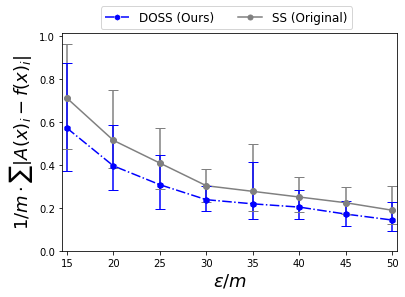

In [7]:
n = 150; m = 1

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

x = DOSS_chi2_test(n,4)

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOLS_chi2(x,n,m)

jj = 10
for j in range(jj):
    acc = accuracy(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.05)
plt.xlim(14.5, 50.5)
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS (Ours)")
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS (Original)")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_all_m=1.png")
fig.savefig("figs/Accuracy_chi2_all_m=1.eps", bbox_inches="tight", pad_inches=0.05)

[[0.64763901 0.70104401]
 [0.31926513 0.36486721]
 [0.3844537  0.42511708]
 [0.31850959 0.37048055]
 [0.29984435 0.32824684]
 [0.29935894 0.31154047]
 [0.21603261 0.242829  ]
 [0.26139811 0.28665465]]
[[0.44856643 0.51393262]
 [0.37603666 0.42661397]
 [0.3234034  0.38021035]
 [0.30797457 0.35176941]
 [0.24057596 0.26302516]
 [0.21507631 0.23763147]
 [0.27570186 0.30769429]
 [0.20125892 0.23052123]]
[[0.63231525 0.74345593]
 [0.47720693 0.53700969]
 [0.3049638  0.34727874]
 [0.33178813 0.3767176 ]
 [0.26816053 0.32183159]
 [0.20955794 0.23856702]
 [0.18246614 0.21205958]
 [0.21262265 0.24099947]]
[[0.61799297 0.73347665]
 [0.4000681  0.47339182]
 [0.3872461  0.44607356]
 [0.37990016 0.4303562 ]
 [0.32773095 0.3635307 ]
 [0.1729962  0.19646696]
 [0.20249035 0.22203885]
 [0.19594474 0.22303678]]
[[0.52451794 0.59127199]
 [0.39226008 0.43409843]
 [0.30946896 0.33979429]
 [0.26881989 0.29314118]
 [0.28232419 0.31220872]
 [0.27289334 0.32650938]
 [0.18212412 0.20540673]
 [0.23562244 0.273931

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.39934637 0.4440777 ]
 [0.3685558  0.42661397]
 [0.2178187  0.24399325]
 [0.29946921 0.34428496]
 [0.21284826 0.23308733]
 [0.22064843 0.25447149]
 [0.24833139 0.26361916]
 [0.18951341 0.22153989]]
[[0.51866078 0.58952562]
 [0.37545183 0.42923353]
 [0.32308981 0.36374454]
 [0.29736147 0.33917058]
 [0.25561478 0.28697541]
 [0.21607608 0.2455837 ]
 [0.21816169 0.24465854]
 [0.20021523 0.22879981]]


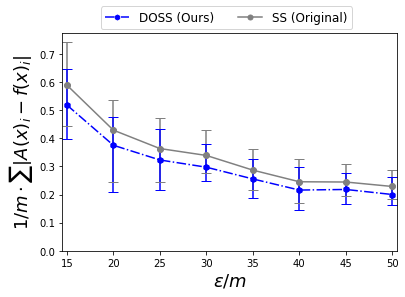

In [8]:
n = 150; m = 2

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOLS_chi2(x,n,m)

jj = 10
for j in range(jj):
    acc = accuracy(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.03)
plt.xlim(14.5, 50.5)
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS (Ours)")
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS (Original)")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_all_m=2.png")
fig.savefig("figs/Accuracy_chi2_all_m=2.eps", bbox_inches="tight", pad_inches=0.05)

[[0.61476724 0.66352997]
 [0.43141381 0.48392787]
 [0.3649024  0.38814009]
 [0.30246004 0.33592244]
 [0.35429756 0.37274562]
 [0.2139397  0.23510413]
 [0.25444403 0.2766094 ]
 [0.18840154 0.19955788]]
[[0.71869794 0.7832647 ]
 [0.41235271 0.45149971]
 [0.4074475  0.44202072]
 [0.2553686  0.28353849]
 [0.23056641 0.25301089]
 [0.2376302  0.25318907]
 [0.18383156 0.2039925 ]
 [0.24023065 0.2639153 ]]
[[0.59129223 0.64690014]
 [0.54857713 0.59742642]
 [0.32558925 0.36020198]
 [0.30634776 0.33259647]
 [0.23253434 0.24944736]
 [0.27976944 0.30931472]
 [0.17341342 0.19124297]
 [0.20455627 0.2170192 ]]
[[0.48874615 0.53381734]
 [0.34019468 0.3729238 ]
 [0.42285227 0.45399419]
 [0.21545295 0.23032306]
 [0.30260205 0.32285615]
 [0.21658549 0.23260966]
 [0.22912807 0.24723005]
 [0.19025127 0.20903688]]
[[0.57207483 0.64024821]
 [0.46309617 0.49889471]
 [0.27574516 0.3023302 ]
 [0.37194396 0.40244173]
 [0.25084658 0.26869044]
 [0.24571893 0.26815591]
 [0.21414802 0.23558917]
 [0.1834176  0.200555

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


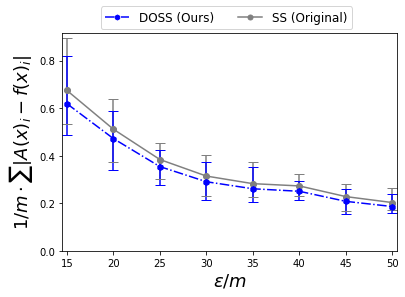

In [9]:
n = 150; m = 3

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOLS_chi2(x,n,m)

jj = 10
for j in range(jj):
    acc = accuracy(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.02)
plt.xlim(14.5, 50.5)
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS (Ours)")
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS (Original)")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_all_m=3.png")
fig.savefig("figs/Accuracy_chi2_all_m=3.eps", bbox_inches="tight", pad_inches=0.05)

[[0.51983925 0.55807948]
 [0.46290936 0.49194344]
 [0.31329139 0.33847158]
 [0.3465065  0.37809281]
 [0.30463079 0.33495123]
 [0.20635555 0.22513434]
 [0.21988527 0.23233179]
 [0.16506318 0.17829552]]
[[0.6846044  0.72840244]
 [0.46800522 0.49919122]
 [0.30658956 0.33629724]
 [0.2990801  0.31950654]
 [0.29266357 0.31838486]
 [0.20803973 0.22468135]
 [0.18533313 0.20092472]
 [0.13906536 0.15039155]]
[[0.53752501 0.57015912]
 [0.32943149 0.35785941]
 [0.38954027 0.42834412]
 [0.29791135 0.32313043]
 [0.26843354 0.29560611]
 [0.25188798 0.26816806]
 [0.2027378  0.22146011]
 [0.19946642 0.21924551]]
[[0.59791557 0.62934937]
 [0.43460221 0.47835384]
 [0.33825738 0.37108661]
 [0.28826775 0.30803088]
 [0.26738977 0.28835832]
 [0.27284229 0.2971592 ]
 [0.20135151 0.22146011]
 [0.19773344 0.21417206]]
[[0.48848712 0.52908834]
 [0.40898848 0.43396115]
 [0.27674222 0.29933354]
 [0.35501048 0.3750729 ]
 [0.26227173 0.28162823]
 [0.25199507 0.26998001]
 [0.20668712 0.22347338]
 [0.18483538 0.197502

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.66507928 0.70907501]
 [0.44876181 0.48378968]
 [0.37167841 0.40080254]
 [0.32972028 0.36057733]
 [0.23885438 0.25833178]
 [0.23312506 0.2500486 ]
 [0.22302967 0.24602205]
 [0.18301809 0.19895171]]
[[0.60706228 0.6486768 ]
 [0.45897407 0.49058448]
 [0.34493411 0.37478299]
 [0.30431737 0.32796229]
 [0.27006451 0.29322469]
 [0.23261849 0.25136226]
 [0.2068895  0.2228694 ]
 [0.18175142 0.1958714 ]]


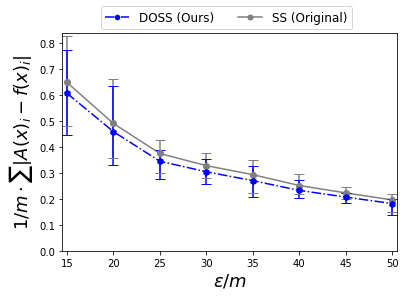

In [10]:
n = 150; m = 4

acc = np.zeros((8,2))
max_acc = np.zeros((8,2)); min_acc = np.ones((8,2))
sum_acc = np.zeros((8,2))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOLS_chi2(x,n,m)

jj = 10
for j in range(jj):
    acc = accuracy(n,m,DOLSP,DOLSN)
    for i in range(8):
        for k in range(2):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,8,2))
for k in range(2):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

ei = [15+5*i for i in range(8)]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(2))+0.01)
plt.xlim(14.5, 50.5)
plt.plot(ei, acc[:,0], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "DOSS (Ours)")
plt.plot(ei, acc[:,1], marker="o", markersize=5, color = "gray", linestyle = "-", label = "SS (Original)")
plt.errorbar(ei, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='o', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.errorbar(ei, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=12)
plt.xlabel("$\epsilon/m$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_all_m=4.png")
fig.savefig("figs/Accuracy_chi2_all_m=4.eps", bbox_inches="tight", pad_inches=0.05)